<a href="https://colab.research.google.com/github/mengjie514/Dynamic-Social-Network-Analysis/blob/main/Dynamic_Social_Network_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import warnings
import random
import math
import string
import re
import json
import requests
import ast
from itertools import product
from inspect import getsourcefile
from io import open

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import networkx as nx

# Install fuzzywuzzy package
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz, process

from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Change to the target directory
os.chdir("/path/to/directory/Raw_Data_2018Midterm")

# Set maximum column width for display
pd.set_option('display.max_colwidth', None)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Mounted at /content/gdrive


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
df_sna_filtered_2018 = pd.read_csv('/path/to/df_sna_filtered_2018.csv', encoding='utf-8', index_col=0)
df_sna_filtered_2022 = pd.read_csv('/path/to/df_sna_filtered_2022.csv', encoding='utf-8', index_col=0)

df_sna_filtered_2018 = df_sna_filtered_2018.reset_index()
df_sna_filtered_2022 = df_sna_filtered_2022.reset_index()

def process_dataframe(df_sna_filtered):
    # Create a new DataFrame that counts the number of interactions between users
    interaction_weights = df_sna_filtered.groupby(['screen_name', 'connected_screen_name']).size().reset_index(name='weight')
    df_sna_graph = df_sna_filtered.merge(interaction_weights, on=['screen_name', 'connected_screen_name'], how='left')
    df_sna_graph = df_sna_graph.drop(columns=['created_at', 'full_text'])
    df_sna_graph = df_sna_graph.drop_duplicates()

    # Calculating weighted interactions
    weighted_ingroup_d = df_sna_graph[
        (df_sna_graph['screen_name_party'] == 'D') &
        (df_sna_graph['connected_screen_name_party'] == 'D')]['weight'].sum()
    weighted_ingroup_r = df_sna_graph[
        (df_sna_graph['screen_name_party'] == 'R') &
        (df_sna_graph['connected_screen_name_party'] == 'R')]['weight'].sum()
    weighted_outgroup_d_r = df_sna_graph[
        (df_sna_graph['screen_name_party'] == 'D') &
        (df_sna_graph['connected_screen_name_party'] == 'R')]['weight'].sum()
    weighted_outgroup_r_d = df_sna_graph[
        (df_sna_graph['screen_name_party'] == 'R') &
        (df_sna_graph['connected_screen_name_party'] == 'D')]['weight'].sum()

    # Calculate the number of unique nodes in each party
    unique_d = df_sna_graph[df_sna_graph['screen_name_party'] == 'D']['screen_name'].nunique()
    unique_r = df_sna_graph[df_sna_graph['screen_name_party'] == 'R']['screen_name'].nunique()

    # Weighted densities
    weighted_density_d_ingroup = weighted_ingroup_d / (unique_d * (unique_d - 1)) if unique_d > 1 else 0
    weighted_density_r_ingroup = weighted_ingroup_r / (unique_r * (unique_r - 1)) if unique_r > 1 else 0
    weighted_density_d_outgroup = weighted_outgroup_d_r / (unique_d * unique_r) if unique_d > 0 and unique_r > 0 else 0
    weighted_density_r_outgroup = weighted_outgroup_r_d / (unique_r * unique_d) if unique_r > 0 and unique_d > 0 else 0

    print("Ingroup vs. Outgroup Density:")
    print(f"Weighted Ingroup Density for D party: {weighted_density_d_ingroup}")
    print(f"Weighted Outgroup Density for D party communicating with R: {weighted_density_d_outgroup}")
    print(f"Weighted Ingroup Density for R party: {weighted_density_r_ingroup}")
    print(f"Weighted Outgroup Density for R party communicating with D: {weighted_density_r_outgroup}")

    # Graph analysis
    G = nx.from_pandas_edgelist(df_sna_graph, 'screen_name', 'connected_screen_name', ['weight'])

    # Subgraphs for ingroup and outgroup connections within each party
    dem_nodes = df_sna_graph[df_sna_graph['screen_name_party'] == 'D']['screen_name'].unique()
    rep_nodes = df_sna_graph[df_sna_graph['screen_name_party'] == 'R']['screen_name'].unique()

    G_dems_ingroup = G.subgraph(dem_nodes)
    G_reps_ingroup = G.subgraph(rep_nodes)

    # Subgraphs for outgroup interactions (cross-party)
    G_dems_outgroup = G.subgraph(
        df_sna_graph[(df_sna_graph['screen_name_party'] == 'D') &
                     (df_sna_graph['connected_screen_name_party'] == 'R')]['screen_name'].unique())
    G_reps_outgroup = G.subgraph(
        df_sna_graph[(df_sna_graph['screen_name_party'] == 'R') &
                     (df_sna_graph['connected_screen_name_party'] == 'D')]['screen_name'].unique())

    # Calculate average degrees
    average_degree_dems_ingroup = sum(dict(G_dems_ingroup.degree()).values()) / len(G_dems_ingroup) if len(G_dems_ingroup) > 0 else 0
    average_degree_reps_ingroup = sum(dict(G_reps_ingroup.degree()).values()) / len(G_reps_ingroup) if len(G_reps_ingroup) > 0 else 0
    average_degree_dems_outgroup = sum(dict(G_dems_outgroup.degree()).values()) / len(G_dems_outgroup) if len(G_dems_outgroup) > 0 else 0
    average_degree_reps_outgroup = sum(dict(G_reps_outgroup.degree()).values()) / len(G_reps_outgroup) if len(G_reps_outgroup) > 0 else 0

    print("Ingroup vs. Outgroup Degree:")
    print(f'Democratic Party Ingroup Average Degree: {average_degree_dems_ingroup}')
    print(f'Democratic Party Outgroup Average Degree: {average_degree_dems_outgroup}')
    print(f'Republican Party Ingroup Average Degree: {average_degree_reps_ingroup}')
    print(f'Republican Party Outgroup Average Degree: {average_degree_reps_outgroup}')

In [ ]:
def prepare_sna_graph(df):
    # Group interactions by users and count, then reset index to turn it back into a DataFrame
    interaction_weights = df.groupby(['screen_name', 'connected_screen_name']).size().reset_index(name='weight')

    # Merge this DataFrame with the original one to add the weight column
    df_sna_graph = df.merge(interaction_weights, on=['screen_name', 'connected_screen_name'], how='left')

    # Remove unnecessary columns
    df_sna_graph = df_sna_graph.drop(columns=['created_at', 'full_text'])

    # Remove duplicates
    df_sna_graph = df_sna_graph.drop_duplicates()

    return df_sna_graph

# Assuming df_sna_filtered_2018 and df_sna_filtered_2022 are already loaded
df_sna_graph_2018 = prepare_sna_graph(df_sna_filtered_2018)
df_sna_graph_2022 = prepare_sna_graph(df_sna_filtered_2022)

print("Data for 2018 and 2022 has been prepared and is ready for network analysis.")

Data for 2018 and 2022 has been prepared and is ready for network analysis.


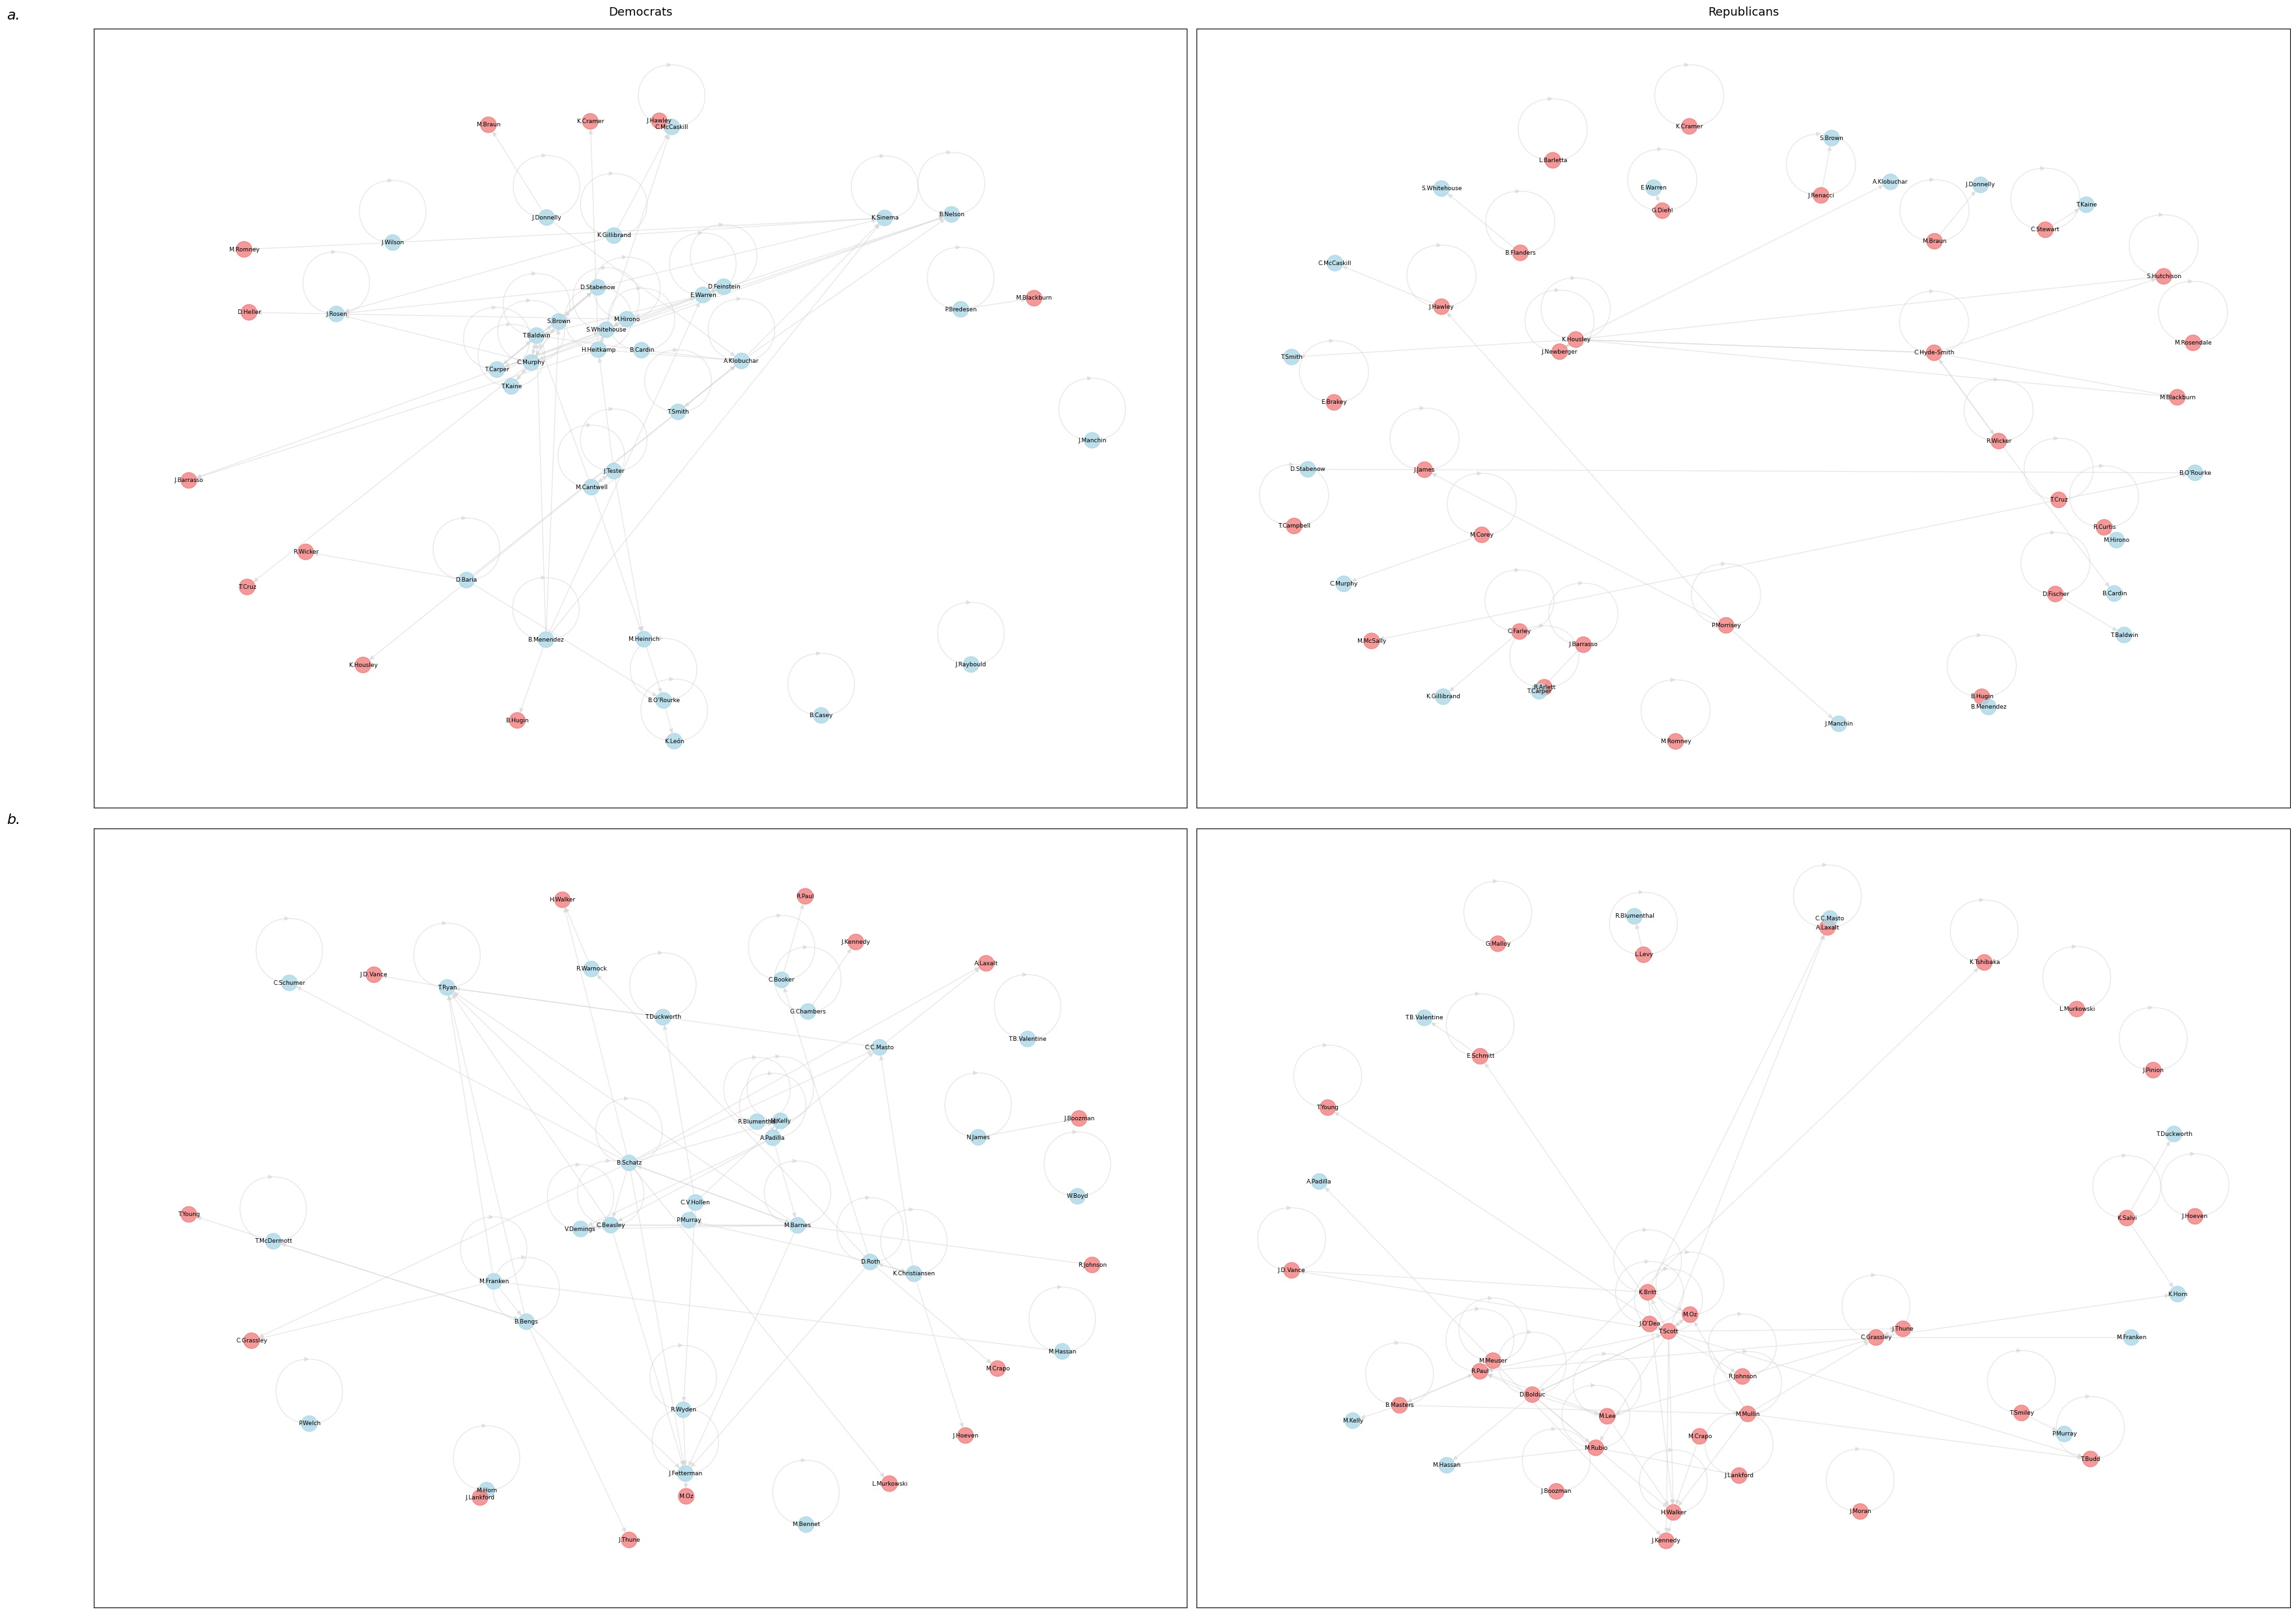

In [ ]:
def initialize_network(df):
    """
    Initializes directed graphs for Democratic and Republican parties from the provided DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing social network data with columns:
                           'screen_name', 'connected_screen_name',
                           'weight', 'screen_name_party', 'connected_screen_name_party'

    Returns:
        tuple: A tuple containing two directed graphs (democratic_network, republican_network)
    """
    democratic_network = nx.DiGraph()
    republican_network = nx.DiGraph()

    for _, row in df.iterrows():
        source = row['screen_name']
        target = row['connected_screen_name']
        weight = row['weight']
        source_color = 'lightblue' if row['screen_name_party'] == 'D' else 'lightcoral'
        target_color = 'lightblue' if row['connected_screen_name_party'] == 'D' else 'lightcoral'

        # Add to Democratic network
        if row['screen_name_party'] == 'D':
            democratic_network.add_node(source, color=source_color)
            democratic_network.add_node(target, color=target_color)
            democratic_network.add_edge(source, target, weight=weight)

        # Add to Republican network
        if row['screen_name_party'] == 'R':
            republican_network.add_node(source, color=source_color)
            republican_network.add_node(target, color=target_color)
            republican_network.add_edge(source, target, weight=weight)

    return democratic_network, republican_network

def plot_networks(dem_network, rep_network, title_prefix=''):
    """
    Plots the Democratic and Republican networks using matplotlib.

    Parameters:
        dem_network (nx.DiGraph): Directed graph for the Democratic party.
        rep_network (nx.DiGraph): Directed graph for the Republican party.
        title_prefix (str): Prefix for subplot titles to indicate the year or other distinctions.
    """
    # Define positions using spring layout
    pos_dem = nx.spring_layout(dem_network, k=0.15, iterations=50)
    pos_rep = nx.spring_layout(rep_network, k=0.15, iterations=50)

    # Draw Democratic network
    ax = plt.subplot(2, 2, 1 if title_prefix == '2018' else 3)
    nx.draw_networkx_nodes(
        dem_network, pos_dem,
        node_color=[data['color'] for _, data in dem_network.nodes(data=True)],
        alpha=0.8
    )
    nx.draw_networkx_edges(
        dem_network, pos_dem,
        edge_color='lightgrey', alpha=0.5
    )
    nx.draw_networkx_labels(
        dem_network, pos_dem, font_size=6.5
    )
    plt.title(f'{title_prefix} Democrats', fontsize=13, y=1.01)
    ax.text(
        -0.08, 1.025, 'a.' if title_prefix == '2018' else 'b.',
        transform=ax.transAxes, fontsize=16,
        verticalalignment='top', horizontalalignment='left',
        fontstyle='italic'
    )

    # Draw Republican network
    ax = plt.subplot(2, 2, 2 if title_prefix == '2018' else 4)
    nx.draw_networkx_nodes(
        rep_network, pos_rep,
        node_color=[data['color'] for _, data in rep_network.nodes(data=True)],
        alpha=0.8
    )
    nx.draw_networkx_edges(
        rep_network, pos_rep,
        edge_color='lightgrey', alpha=0.5
    )
    nx.draw_networkx_labels(
        rep_network, pos_rep, font_size=6.5
    )
    plt.title(f'{title_prefix} Republicans', fontsize=13, y=1.01 if title_prefix == '2018' else None)
    if title_prefix == '2022':
        ax.text(
            -0.08, 1.02, 'b.',
            transform=ax.transAxes, fontsize=16,
            verticalalignment='top', horizontalalignment='left',
            fontstyle='italic'
        )

# Initialize directed graphs for 2018
democratic_network_2018, republican_network_2018 = initialize_network(df_sna_graph_2018)

# Initialize directed graphs for 2022
democratic_network_2022, republican_network_2022 = initialize_network(df_sna_graph_2022)

# Set up the figure
plt.figure(figsize=(35, 25))  # Adjusted figure size for better visualization

# Plot networks for 2018
plot_networks(democratic_network_2018, republican_network_2018, title_prefix='2018')

# Plot networks for 2022
plot_networks(democratic_network_2022, republican_network_2022, title_prefix='2022')

# Add main title to the figure
plt.suptitle('Social Network Analysis of Political Parties (2018 vs. 2022)', fontsize=16, fontweight='bold', y=1.02)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()